In [4]:
import pandas as pd
import numpy as np
import random
import os
from IPython.display import clear_output
from google.cloud import bigquery # SQL table interface on Arcus
from dxFilterLibraryPreGrading import *
from reportMarkingFunctions import *
from projectTableFunctions import * 
import json

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Initialize the client service
client = bigquery.Client()

In [ ]:
query = '''select
  distinct pat_id,
  proc_ord_id,
  proc_ord_age,
  proc_ord_year,
from
  lab.requested_sessions_main_with_metadata
where
  project like "%SLIP%"
  and request_label not like "%2024-06%"
  and request_label not like "%2024-07%"
  and request_label not like "%2024-08%"'''
df = client.query(query).to_dataframe()
# df.to_csv("/home/youngjm/arcus/shared/2024-09_slip_release_patients.csv", index=False)

# pd.read_csv("/home/youngjm/arcus/shared/2024-09_slip_release_patients.csv").shape


In [2]:
backup_grader_table()

lab.grader_table_with_metadata backup successful


In [ ]:
## This is about testing the process for adding multiple cohorts to individuals
import json
import os

# check_table_for_cohort_includi
table_name = "lab.grader_table_with_metadata"
config_fn = "/home/youngjm/bgdlab/code/annotation-helper-tools/queries/config.json"

# THIS IS A FUNCTION
# Load the config file
with open(config_fn, "r") as f:
    dict_query = json.load(f)

# The following is only for running on the grader_table_with_metadata, it 
# is not suited for running during report queuing yet
for cohort in list(dict_query):
    print(cohort)
    # Load cohort config
    q_cohort = load_cohort_config(cohort)
    
    # Modify the query to get any patient in the specified table
    # who is identified with the query and the dx filter but not 
    # tagged with the cohort name 
    q_cohort_updated = "with CTE as ("+q_cohort.replace(';', ' ')+") select my_tab.* from "+table_name
    q_cohort_updated +=' my_tab join CTE on my_tab.proc_ord_id = CTE.proc_ord_id where project not like "%'+cohort
    q_cohort_updated +='%" and grader_name not like "%Coarse Text Search%"; '
    
    # Run the query to get the proc ord ids and their project names
    df = client.query(q_cohort_updated).to_dataframe()
    print(df.shape)
    
    # For each row in the dataframe
    for idx, row in df.iterrows():
        # Get the project column
        proj = row['project']
        projects = proj.replace("; ", ";").split(";")
        projects.append(cohort)
        # Create the updated string for the project column 
        # -- Do I want this sorted alphabetically by project name?
        updated_projects = "; ".join(sorted(projects))
        # Write the update query
        q_update_projects = 'update '+table_name+' set project="'+updated_projects
        q_update_projects += '" where pat_id="'+row['pat_id']+'" and proc_ord_id="'
        q_update_projects += row['proc_ord_id']+'" and grader_name="'+row['grader_name']+'" ;'
        job = client.query(q_update_projects)
        job.result()

print("Project Cohorts updated")




SLIP Neonates
(0, 11)
SLIP Toddlers
(0, 11)
SLIP PreK
(0, 11)
SLIP Elementary
(0, 11)
SLIP Adolescents
(1833, 11)


In [ ]:
# 2024-08-15 Get any reports that qualify for 

q_slip = 'select * from lab.grader_table_with_metadata where project like "%SLIP%" and project like "%;%"'

df_slip = client.query(q_slip).to_dataframe()
print(df_slip.shape)
    
# For each row in the dataframe
for idx, row in df_slip.iterrows():
    # Get the project column
    proj = row['project']
    projects = proj.replace("; ", ";").split(";")

    # if "SLIP" occurs twice in the list of projects
    slip_cohorts = [i for i in projects if "SLIP" in i]
    if len(slip_cohorts) == 2:
        try:
            projects.remove("SLIP")
        except:
            age_in_years = row['age_in_days']/365.25
            # print("ERROR:", projects, age_in_years, row['proc_ord_year'])
            if "SLIP Adolescents" in projects and "SLIP Elementary" in projects:
                if age_in_years >= 12 and age_in_years <= 20:
                    projects.remove("SLIP Elementary")
                elif age_in_years > 5:
                    projects.remove("SLIP Adolescents")
        # Create the updated string for the project column 
        updated_projects = "; ".join(sorted(projects))
        print(updated_projects)
        # Write the update query
        q_update_projects = 'update '+table_name+' set project="'+updated_projects
        q_update_projects += '" where pat_id="'+row['pat_id']+'" and proc_ord_id="'
        q_update_projects += row['proc_ord_id']+'" and grader_name="'+row['grader_name']+'" ;'
        job = client.query(q_update_projects)
        job.result()
    elif len(slip_cohorts) == 1:
        pass

print("SLIP Cohorts updated")

(24101, 11)
SLIP Neonates
SLIP Neonates
SLIP Neonates
SLIP Neonates
SLIP Toddlers
SLIP Toddlers
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP Adolescents
SLIP PreK
SLIP PreK
SLIP PreK
SLIP PreK
SLIP Neonates
SLIP Neonates
SLIP Neonates
SLIP Neonates
SLIP Neonates
SLIP Neonates
SLIP Neonates
SLIP Neonates
SLIP Neonates
SLIP Neonates
SLIP Neonates
SLIP Neonates
SLIP Toddlers
SLIP Toddlers
SLIP Toddlers
SLIP Toddlers
SLIP Toddlers
SLIP Toddlers
SLIP Toddlers
SLI

In [9]:
import matplotlib.pyplot as plt
import numpy as np

q = '''select
  pat_id,
  proc_ord_id,
  proc_ord_desc,
  proc_ord_age,
  proc_ord_year
from
  arcus.procedure_order
where
  proc_ord_desc like "MR FETAL%"
order by proc_ord_age'''

df = client.query(q).to_dataframe()
df['age_in_years'] = df['proc_ord_age'].astype(int)/365.25

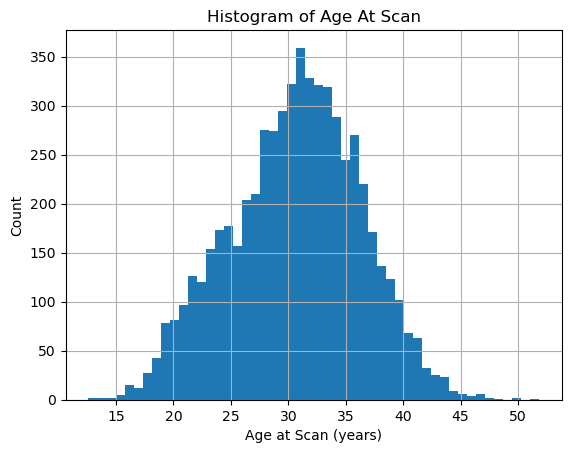

In [14]:
plt.hist(df['age_in_years'], bins = 50)
plt.title("Histogram of Age At Scan")
plt.xlabel("Age at Scan (years)")
plt.ylabel("Count")
plt.grid(visible=True)

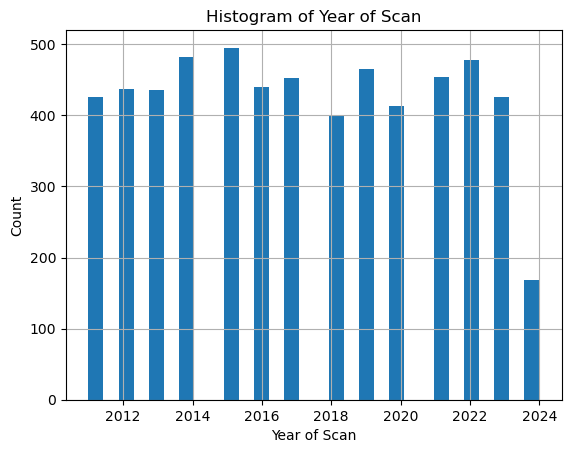

In [16]:
plt.hist(df['proc_ord_year'], bins = 30)
plt.title("Histogram of Year of Scan")
plt.xlabel("Year of Scan")
plt.ylabel("Count")
plt.grid(visible=True)

In [19]:
len(list(df['pat_id'].values))

5973

In [2]:
# Rectifying the dropped table issue
existing_db = "lab.grader_table_with_metadata"
restored_db = "lab.grader_table_with_metadata_restored_2024_08_20_1145am"

existing_df = client.query('select * from '+existing_db).to_dataframe()
restored_df = client.query('select * from '+restored_db).to_dataframe()

existing_df = existing_df.drop_duplicates()
restored_df = restored_df.drop_duplicates()

print(existing_df.shape)
print(restored_df.shape)

(222038, 11)
(221465, 11)


In [7]:
df_all = existing_df.merge(restored_df.drop_duplicates(), 
                   how='outer', indicator=True)
set(list(df_all['_merge'].values))
df_all = df_all[df_all['_merge'] != 'both'].drop_duplicates()

In [16]:
# for idx, row in df_all[df_all['_merge'] != 'all'].iterrows():
graded_reports = zip(df_all['proc_ord_id'].values,
                        df_all['grader_name'].values)
rows = []
for proc, name in graded_reports:
    smol_df = df_all[(df_all['proc_ord_id'] == proc) & (df_all['grader_name'] == name)]
    
    if smol_df.shape[0] > 1:
        smol_df = smol_df[smol_df['grade'] != 999]
        rows.append(smol_df)
    elif smol_df.shape[0] == 1 and smol_df['_merge'].values == ['right_only']:
        rows.append(smol_df)

tmp = pd.concat(rows)
print(tmp.shape)
tmp

(20, 12)


,proc_ord_id,grader_name,grade,grade_category,pat_id,age_in_days,proc_ord_year,proc_name,report_origin_table,project,grade_date,_merge
62472,437834289052,Jenna Schabdach,1,Unique,HM3KAREVC,1655,2023,MR BRAIN W & W/O IV CONTRAST,arcus.procedure_order,SLIP PreK,2024-08-21,left_only
62501,437830263287,Jenna Schabdach,1,Unique,HM40XDTU0,963,2023,MR BRAIN W/O IV CONTRAST,arcus.procedure_order,SLIP PreK,2024-08-21,left_only
62677,437738205346,Jenna Schabdach,1,Unique,HM3L9RA4Q,1583,2023,MR BRAIN W/O IV CONTRAST,arcus.procedure_order,SLIP PreK; Pb Cohort,2024-08-21,left_only
62697,438365915960,Jenna Schabdach,1,Unique,HM3P1DZLD,1238,2023,MR BRAIN W & W/O IV CONTRAST,arcus.procedure_order,SLIP PreK,2024-08-21,left_only
62771,437781738772,Jenna Schabdach,0,Unique,HM3J6VO9N,1740,2023,MR BRAIN W & W/O IV CONTRAST,arcus.procedure_order,SLIP PreK; Clinical Imaging Genetics,2024-08-21,left_only
62863,436678890231,Jenna Schabdach,2,Unique,HM3RZMRKH,945,2023,MR BRAIN W/O IV CONTRAST,arcus.procedure_order,SLIP PreK; Pb Cohort,2024-08-21,left_only
63011,436639168851,Jenna Schabdach,0,Unique,HM3RN22SA,993,2023,MR BRAIN W & W/O IV CONTRAST,arcus.procedure_order,SLIP PreK,2024-08-21,left_only
63200,437459435605,Jenna Schabdach,1,Unique,HM2U56QEY,1816,2023,MR BRAIN W/O IV CONTRAST,arcus.procedure_order,SLIP PreK,2024-08-21,left_only
63263,438127917466,Jenna Schabdach,1,Unique,HM3N51RW5,1428,2023,MR BRAIN W/O IV CONTRAST,arcus.procedure_order,SLIP PreK,2024-08-21,left_only
63548,436789170742,Jenna Schabdach,2,Unique,HM3JHKWU9,1715,2023,MR BRAIN W & W/O IV CONTRAST,arcus.procedure_order,SLIP PreK; Pb Cohort,2024-08-21,left_only


In [7]:
q = 'select pat_id, proc_ord_id, project from lab.grader_table_with_metadata where grade_date like "%2024%" ;'
df = client.query(q).to_dataframe()
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

projects = sorted(list(set("; ".join(list(set(df['project'].values))).split("; "))))
for project in projects:
    if project != 'SLIP':
        count = len(df[df['project'].str.contains(project)])
        print(project, count)

(15438, 3)
(8810, 3)
Clinical Fetal 100
Clinical Imaging Genetics 407
Indication Psychosis 146
Pb Cohort 683
SLIP Adolescents 5451
SLIP Elementary 2133
SLIP PreK 220
SLIP Toddlers 100


In [19]:
## And now for something completely different: going to make a separate lab.proc_ord_project table
drop_table = "DROP TABLE lab.proc_ord_projects"
job = client.query(drop_table)
job.result()
create_table = "CREATE TABLE lab.proc_ord_projects (proc_ord_id STRING, pat_id STRING, project STRING)"
job = client.query(create_table)
job.result()

# Read the config file
cfg_fn = "./queries/config.json"
with open(cfg_fn, 'r') as f:
    cfg = json.load(f)
for cohort in cfg:
    # Load the query for the cohort
    print(cohort)
    project_query = load_cohort_config(cohort)
    # Get the pat/proc combos for the project
    df = client.query(project_query).to_dataframe()[['proc_ord_id', 'pat_id']]
    df = df.drop_duplicates()
    # Add the pat/proc combos to the proc_ord_projects table
    count = 0
    add_projects_query = 'insert into lab.proc_ord_projects (proc_ord_id, pat_id, project) VALUES '
    for idx, row in df.iterrows():
        if count < 100:
            add_projects_query += '("'+str(row['proc_ord_id'])+'", "'+str(row['pat_id'])+'", "'+cohort+'"), '
            count += 1
        else:
            add_projects_query = add_projects_query[:-2]+";"
            job = client.query(add_projects_query)
            job.result()
            add_projects_query = 'insert into lab.proc_ord_projects (proc_ord_id, pat_id, project) VALUES '
            count = 0
    add_projects_query = add_projects_query[:-2]+";"
    job = client.query(add_projects_query)
    job.result()


SLIP Neonates
SLIP Toddlers
SLIP PreK
SLIP Elementary
SLIP Adolescents
Clinical Imaging Genetics
VIP Clinical Imaging Genetics
Pb Cohort
Clinical Fetal
Indication Psychosis
22q11


In [23]:
# Next test: how many rows are in our new project table? how many unique pat_ids? for a cohort, are there any duplicate rows?

# 1. How many rows are in our new project table
q_rows = "select proc_ord_id, pat_id, project from lab.proc_ord_projects"
df = client.query(q_rows).to_dataframe()
print(df.shape)

# 2. How many unique patients are in the table?
q_rows = "select distinct pat_id from lab.proc_ord_projects"
df = client.query(q_rows).to_dataframe()
print(df.shape)

# 3. How many unique rows are in the table?
q_rows = "select distinct proc_ord_id, pat_id, project from lab.proc_ord_projects"
df = client.query(q_rows).to_dataframe()
print(df.shape)

(77697, 3)
(53184, 1)
(77697, 3)


In [3]:
# Next step: make copies of existing tables without the project columns.

# grader table
q_make_and_modify = "create table lab.test_grader_table_with_metadata as "
q_make_and_modify += "(select proc_ord_id, grader_name, grade, grade_category, "
q_make_and_modify += "pat_id, age_in_days, proc_ord_year, proc_name, "
q_make_and_modify += "report_origin_table, grade_date from lab.grader_table_with_metadata)"
# job = client.query(q_make_and_modify)
# job.result()

q_test = "select * from lab.test_grader_table_with_metadata"
df = client.query(q_test).to_dataframe()
print(df.shape)
print(df.drop_duplicates().shape)

# request table
q_make_and_modify = "create table lab.test_requested_sessions_main_with_metadata as "
q_make_and_modify += "(select pat_id, proc_ord_id, proc_ord_age, proc_ord_year, "
q_make_and_modify += "proc_ord_desc, report_origin_table, grade_category, avg_grade, "
q_make_and_modify += "sex, race, ethnicity, dob_year, gestational_age_num, "
q_make_and_modify += "birth_weight_kg, birth_length_cm, request_label "
q_make_and_modify += "from lab.requested_sessions_main_with_metadata)"
job = client.query(q_make_and_modify)
job.result()

q_test = "select * from lab.test_requested_sessions_main_with_metadata"
df = client.query(q_test).to_dataframe()
print(df.shape)
print(df.drop_duplicates().shape)

(224999, 10)
(224517, 10)


Conflict: 409 Already Exists: Table scit605-healthymri-2d73d69f:lab.test_requested_sessions_main_with_metadata

Location: US
Job ID: a0204106-b64f-466d-804f-2845b7a1870b


In [3]:
# Load the config
cfg = "./queries/config.json"
with open(cfg, "r") as f:
    cohort_lookup = json.load(f)

cohort_list = list(cohort_lookup.keys())
print(cohort_list)

for cohort in cohort_list:
    print(cohort)
    add_reports_to_project(cohort)

['SLIP Neonates', 'SLIP Toddlers', 'SLIP PreK', 'SLIP Elementary', 'SLIP Adolescents', 'Clinical Imaging Genetics', 'VIP Clinical Imaging Genetics', 'Pb Cohort', 'Clinical Fetal', 'Indication Psychosis', '22q11']
SLIP Neonates


NameError: name 'add_reports_to_project' is not defined

In [5]:
for cohort in cohort_list:
    print()
    get_project_report_stats(cohort)


Project: SLIP Neonates
Total reports: 2003 (note each report must be graded by 2 graders)
Graded 0: 5
Graded 1: 9
Graded 2: 7
Queued: 0
Skipped: 0

Project: SLIP Toddlers
Total reports: 7195 (note each report must be graded by 2 graders)
Graded 0: 90
Graded 1: 37
Graded 2: 135
Queued: 20
Skipped: 2

Project: SLIP PreK
Total reports: 5763 (note each report must be graded by 2 graders)
Graded 0: 76
Graded 1: 178
Graded 2: 303
Queued: 10
Skipped: 2

Project: SLIP Elementary
Total reports: 15009 (note each report must be graded by 2 graders)
Graded 0: 805
Graded 1: 2100
Graded 2: 911
Queued: 289
Skipped: 13

Project: SLIP Adolescents
Total reports: 16484 (note each report must be graded by 2 graders)
Graded 0: 1469
Graded 1: 1875
Graded 2: 2976
Queued: 80
Skipped: 3

Project: Clinical Imaging Genetics
Total reports: 7077 (note each report must be graded by 2 graders)
Graded 0: 3690
Graded 1: 107
Graded 2: 121
Queued: 11
Skipped: 0

Project: VIP Clinical Imaging Genetics
Total reports: 453